## REALISATION D' UNE APPLICATION DE RECOMMANDATION DE CONTENU



### Objectif principal

Mettre en place une application dont l'utilité est définie comme suit:

"En tant qu’utilisateur de l’application, je vais recevoir une sélection de cinq articles."

### Fonctionnalité de l'application

1. Entraînement des modèles

 
 1.a. Choix d'un modèle d'entraînement du type   **Content_based Filtering**
 
 Ce modèle permet de prédire les préférences d'un utilisateur en se basant sur l'historique de ses dernières préférences ou caractéristiques.
 Dans cette  méthode, il n y a aucune nécessité d'utiliser les caractéristiques d'un autre utilisateur pour prédire les préférences de l'utilisateur choisi.
 
 
 1.b. Choix d'un modèle d'entraînement du type **Collaborative Filtering** (CF)
 
 Contrairement à la méthode contend_based, cette méthodologie ne prend pas uniquement en compte l'historique des caractéristiques de l'utilisateur, mais considère plutôt les informations provenant des utilisateurs dont se rapproche l'utilisateur afin de faire une prédiction
 
 
 
         
        
 ### Quelques modèles de recommandations selon la typologie
 
 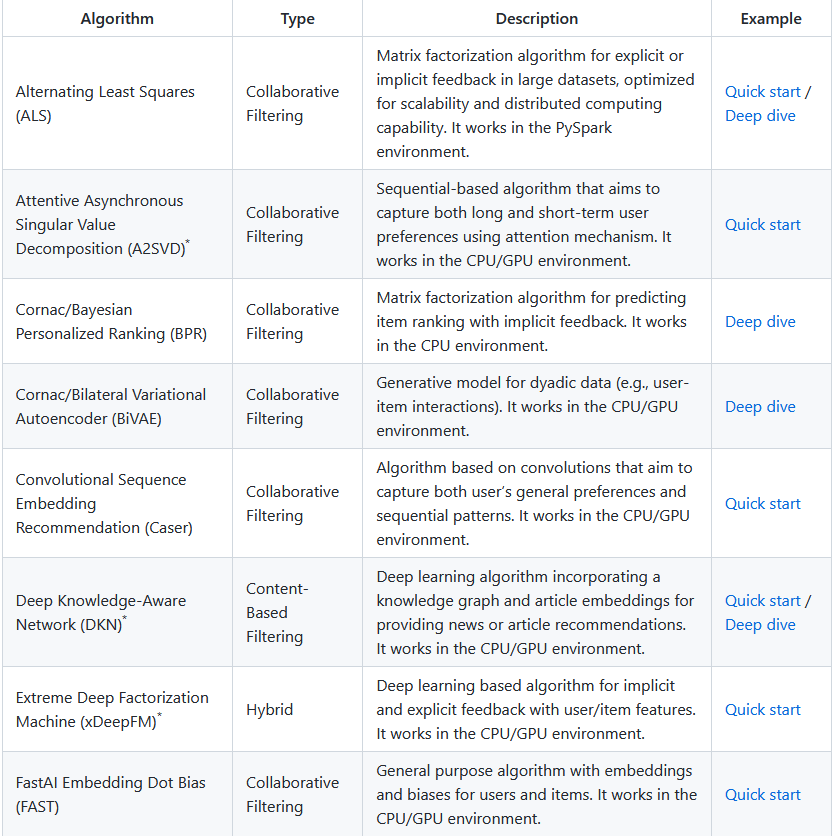
 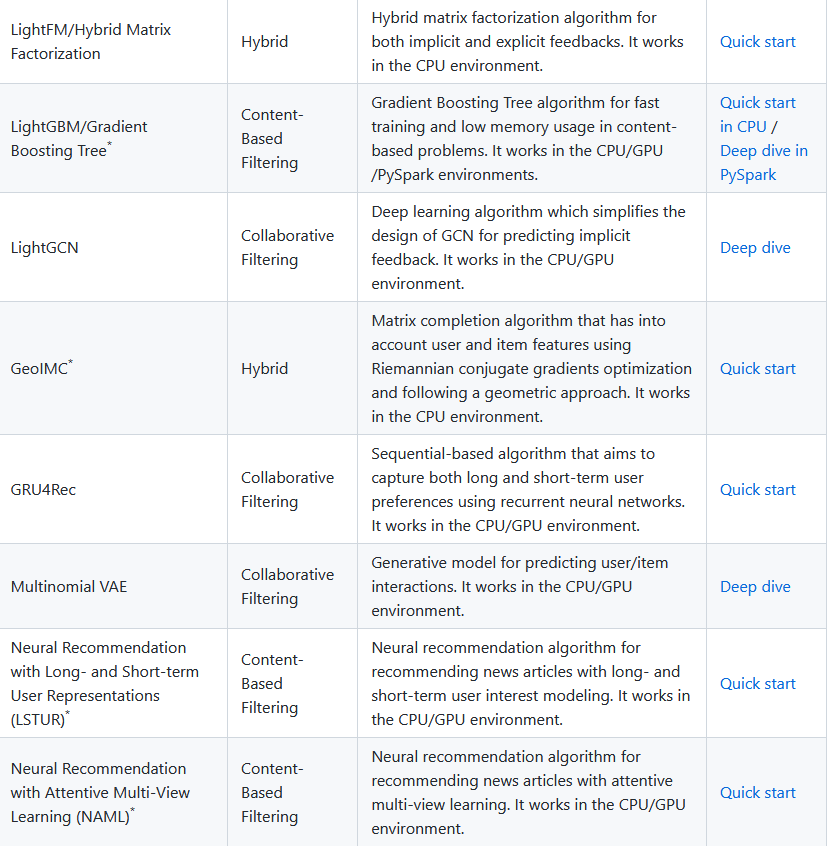
 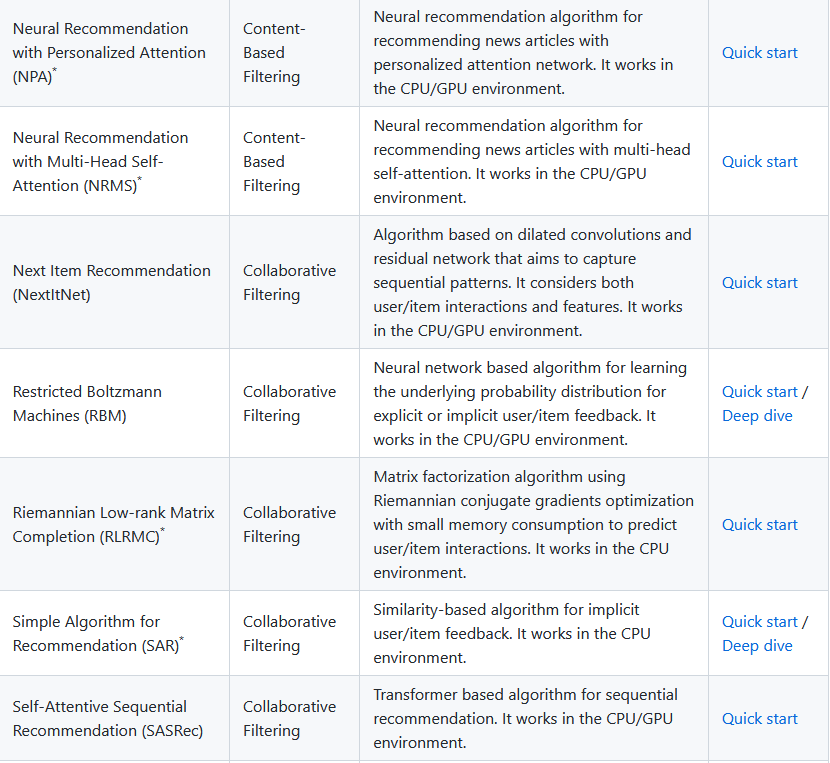
 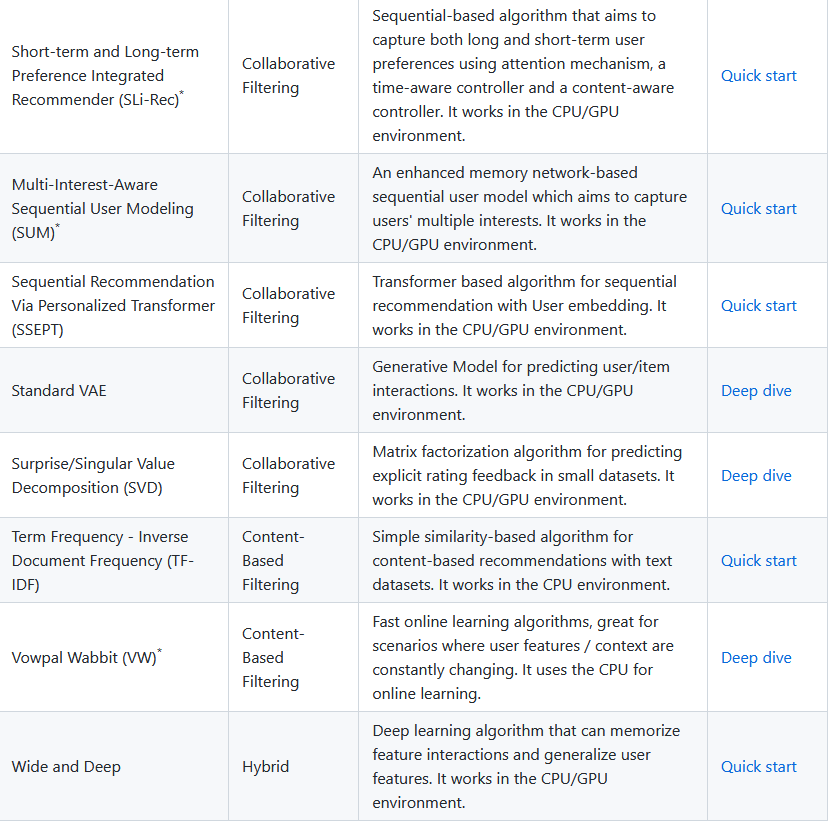
        

 
  
 En plus de ces 2 typologies, il existe 2 autres types de systèmes de recommandation:


    Les "Social and demographic recommenders" proposent des produits aimés par des amis, par les amis d'amis et par des personnes geographiquement similaires. Ce type de système de recommandation ne prend pas en compte l'historique des préférences des utilisateurs, ce qui les rend très efficaces. 
    
    Les algorithmes de recommandation contextuelles ("Contextual recommendation") permettent de faire des recommandation à des utilisateurs selon le contexte dans lequel ils se trouvent. Par exemple si un utilisateur vient d'acheter une voiture, l'algorithme sera à même de lui proposer des offres pour des assurances voitures et autres accessoires ...
 
2. Création de la fonction de prédiction




### Techniques de déploimement de l'application

#### Mise en place d'une **architecture serverless** au choix



  1.a. **Première architecture** *créer une API* pour développer puis exposer le système de recommandation. 
  
       Afin de faire le lien entre l’application et le système de recommandation, créer une Azure Function 
       
  1.b. **Deuxième architecture** *pas de création d'API*
  
        Exploitation des fonctionnalités “Azure Blob storage input binding”.
        Afin de récupérer directement les fichiers et modèles.
        En intégrant les prédictions directement dans l' Azure Functions.
        
        
        
        
        
       
Notre plan de travail étant prêt, il ne nous reste plus qu'à entrer dans le vif du sujet en commençant par l'analyse exploratoire des données qui seront utilisées l'entraînement des modèles choisis...     
        
        
        
        
        
        

    
  
        
        
 
 
    

## A.  Analyse exloratoire des données

In [23]:
# Installation des librairies nécessaires à notre analyse SurPRISE (Simple Python RecommendatIon System Engine)

!pip install scikit-surprise
#Phase effectuée via la ligne de commande anaconda (conda install -c conda-forge scikit-surprise)

  Using cached scikit-surprise-1.1.1.tar.gz (11.8 MB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-win_amd64.whl size=757809 sha256=146ceffd2814b4f83573ef5baa21987daccf980af4ec278d365dbcac96c3f051
  Stored in directory: c:\users\diane\appdata\local\pip\cache\wheels\76\44\74\b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [86]:
# Importation des librairies
import os

import random

import pandas as pd
import numpy as np
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno

import sklearn
import sklearn.model_selection

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNWithMeans, SVD
from surprise import accuracy

import pickle
from random import randint
from scipy.spatial import distance
#Settings
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

#To be avoided in your notebook.
import warnings
warnings.filterwarnings("ignore")

In [38]:
os.chdir(r"C:\Users\diane\Downloads")

Contenu du fichier téléchargé:

    articles_metadata.csv : CSV file avec metadata pour tous les (364047) articles publiés
    articles_embeddings.pickle : Pickle (Python 3) d'une matrice Numpy contenant l'Embedding des mots d'articles (250-dim vectors), entraînés sur des metadata et textes d'articles grâce au module CHAMELEON's ACR pour 364047 articles publiés.
    clicks : Dossier avec fichiers CSV (un par heure), contenant les sessions d'interaction de l'utilisateur dans le nouveau portail.
    clicks_sample.csv : fichier CSV contenant les sessions d'interaction de l'utilisateur dans le nouveau portail.



In [25]:
# Liste des fichiers et dossiers
[print(x) for x in os.listdir('news-portal-user-interactions-by-globocom')];

articles_embeddings.pickle
articles_metadata.csv
clicks
clicks_sample.csv


### Premier fichier  "articles_metadata.csv"

In [26]:
PATH_ARTICLES_DATA = "news-portal-user-interactions-by-globocom/articles_metadata.csv"
articles_df = pd.read_csv(PATH_ARTICLES_DATA)
articles_df.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


<AxesSubplot:>

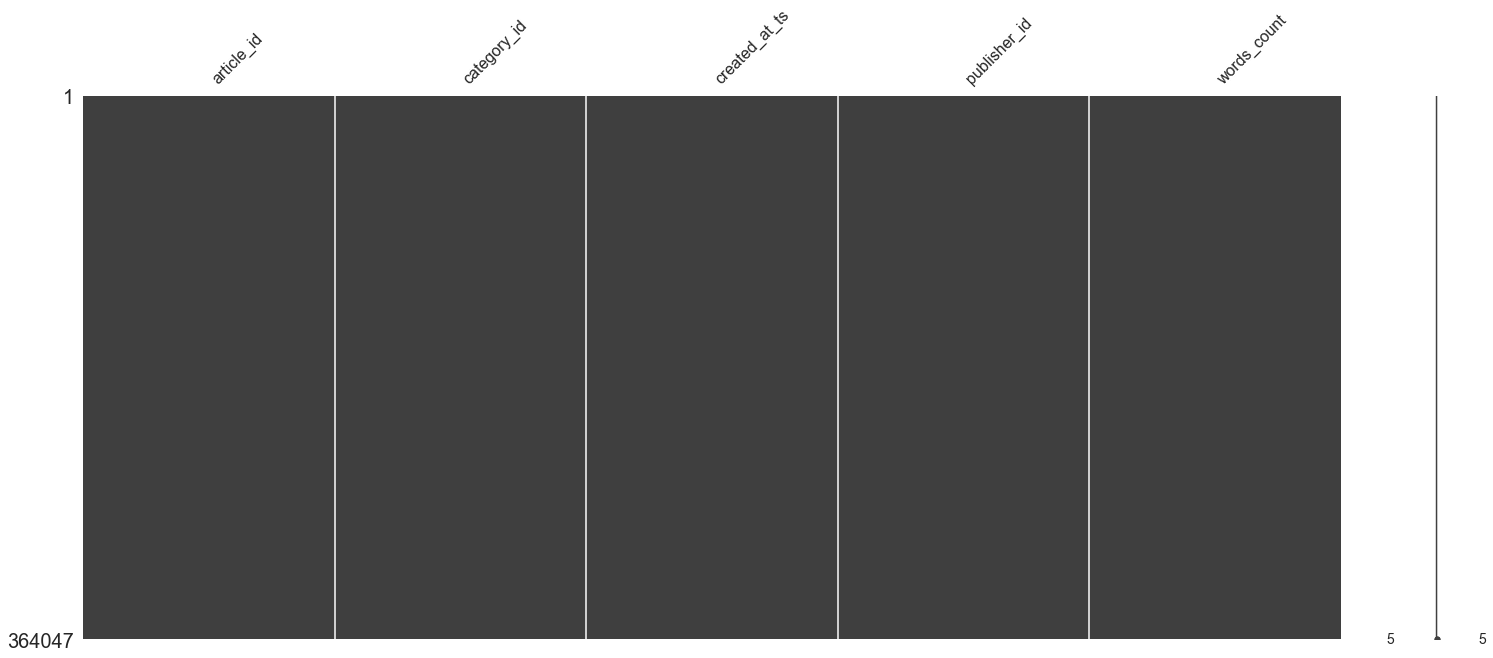

In [27]:
# Valeurs manquantes
missingno.matrix(articles_df)

Notre premier fichier est donc constitué de 5 variables :

    L'id de l'article (article_id)
    L'id donnant la catégorie de l'article (category_id)
    La date de création au format timestamp
    L'id du publisher (publisher_id)
    Le nombre de mots total de l'article (wordss_count)
    
Notons que notre premier fichier n'a pas de valeurs manquantes

In [28]:
# Distributuin du nombre de mots
articles_df['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

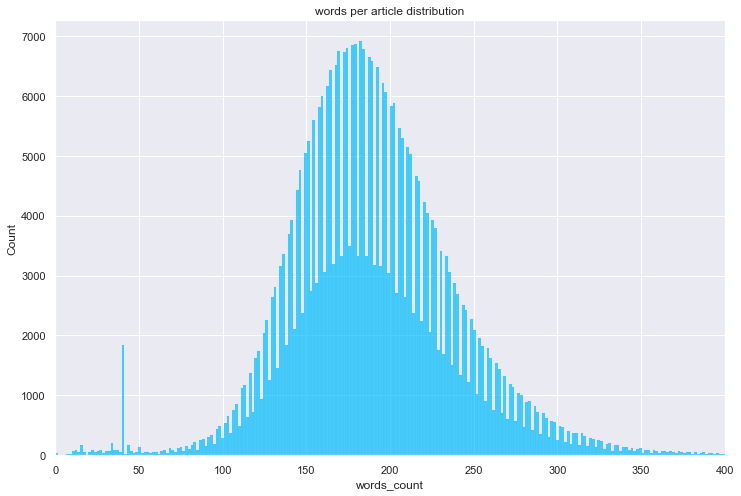

In [29]:
# Représentation de la distrib
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('words per article distribution');
plt.show()

In [30]:
# Vérifs si tous les articles ont un contenu
print(f'Article(s) vide(s) : {articles_df[articles_df["words_count"] == 0].count()[0]}')

Article(s) vide(s) : 35


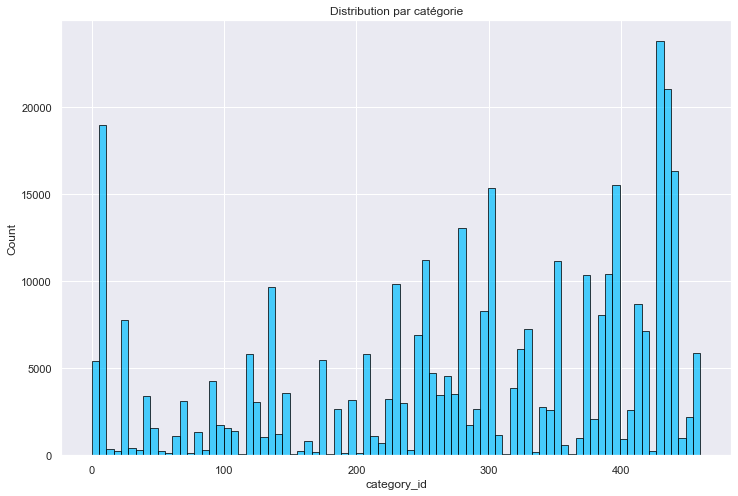

In [31]:
# Distribution d'articles par catégories
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['category_id'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.title('Distribution par catégorie');
plt.show()



### Fichiers clicks_{}.csv

In [32]:
# Fichier click_sample.csv


PATH_CLICK_SAMPLE_DATA = "news-portal-user-interactions-by-globocom/clicks_sample.csv"
clicks_samp_df = pd.read_csv(PATH_CLICK_SAMPLE_DATA)
clicks_samp_df.head()


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [35]:
[print(x) for x in clicks_samp_df.columns];

user_id
session_id
session_start
session_size
click_article_id
click_timestamp
click_environment
click_deviceGroup
click_os
click_country
click_region
click_referrer_type


Le fichier contenant un echantillon de click est constitué de 12 colonnes:
    
    user_id : user ID
    session_id : Session ID
    session_start : Start of the session (timestamp)
    session_size : number of click/session
    words_count : Total word contain in the article
    click_article_id : article ID user clicked
    click_timestamp : When user clicked (timestamp)
    click_environment : user env when click
    click_deviceGroup : user device
    click_os : user OS
    click_country : localisation (country) when user clicked
    click_region : localisation (region) when user clicked
    click_referrer_type : ?

Nous allons à présent concatener tous les fichiers de clicks d'utilisateurs par heure retrouvés dans le dossier de fichiers clicks. Le tableau résultat sera nettoyé et utilisé pour l'entraînement de nos modèles.

In [43]:
%%time

CLICK_FILES_PATH = "news-portal-user-interactions-by-globocom/clicks/"

#Get all .csv contain in clicks folder
click_files = [CLICK_FILES_PATH + x for x in os.listdir(CLICK_FILES_PATH)];

#Sort all files PATH contain in list.
click_files.sort()

#Check if all files are present.
print("Total PATH contain in list : ", len(click_files))

list_click_file_to_df = [pd.read_csv(x, index_col=None, header=0) for x in click_files];

#Remove unused columns
list_click_file_to_df_cleaned = [x.drop(columns = ['session_id',
                                                   'session_start',
                                                   'session_size',
                                                   'click_timestamp',
                                                   'click_environment',
                                                   'click_deviceGroup',
                                                   'click_os',
                                                   'click_country',
                                                   'click_region',
                                                   'click_referrer_type']) for x in list_click_file_to_df]

all_clicks_df = pd.concat(list_click_file_to_df_cleaned, axis=0, ignore_index=True)

print(f"DataFrame shape : {all_clicks_df.shape}")

Total PATH contain in list :  385
DataFrame shape : (2988181, 2)
Wall time: 5.96 s


In [44]:
all_clicks_df.head()

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


## B. Construction des modèles de recommandation



B.1. Préparation des données

Pour l'entraînement de nos modèles, nous devons mettre en place un score qui permettra au modèle de comprendre les préférences de chaque utilisateur

Dans ce travail  le score utilisé est calculé comme suit:


**Rating= Click total par catégorie et par utilisateur / Click total par utilisateur**

In [45]:
# Mapping permettant d'associer les ids d'articles aux catégories

dict_article_categories = articles_df.set_index('article_id')['category_id'].to_dict()

# Ajout des colonnes permettant de calculer la colonne qui donne le score pour chaque utilisateur

all_clicks_df['category_id'] = all_clicks_df['click_article_id'].map(dict_article_categories).astype(int)
all_clicks_df['total_click'] = all_clicks_df.groupby(['user_id'])['click_article_id'].transform('count')
all_clicks_df['total_click_by_category_id'] = all_clicks_df.groupby(['user_id','category_id'])['click_article_id'].transform('count')
all_clicks_df['rating'] = all_clicks_df['total_click_by_category_id'] / all_clicks_df['total_click']

print(f'Taille avant traitement des doublons : {all_clicks_df.shape}')
all_clicks_df = all_clicks_df.drop(['click_article_id'], axis=1)
all_clicks_df = all_clicks_df.drop_duplicates()
print(f'Taille après traitement des doublons : {all_clicks_df.shape}')

Shape before dropping duplicate : (2988181, 6)
Shape after dropping duplicate : (1882302, 5)


In [46]:
#Retrait des colonnes non utiles pour l'entraînement
all_clicks_df = all_clicks_df.drop(['total_click', 'total_click_by_category_id'], axis=1)


In [47]:
# Exemple d'illustration de notre table pour un utilisateur donné
all_clicks_df[all_clicks_df['user_id'] == 2]

,user_id,category_id,rating
4,2,247,0.25
5,2,26,0.50
2979447,2,332,0.25


In [48]:
# Utilisation de 50.000 utilisateurs pour notre analyse
df = all_clicks_df[all_clicks_df['user_id'] < 50000]
print(f'Taille de notre echantillon : {df.shape}')

Taille de notre echantillon : (503723, 3)


Notre table étant prête, nous allons la rendre lisible pour nos modèles de la librairie surprise en définissant un **reader** qui sera associé à notre échantillon

In [50]:
reader = Reader(rating_scale=(0, 1))

#Séparation de notre Dataframe 75% train / 25% test
data = Dataset.load_from_df(df[['user_id', 'category_id', 'rating']], reader)
train_set, test_set = train_test_split(data, test_size=.25)
print(f"Taille de l'echantillon test : {len(test_set)}")



Taille de l'echantillon test : 125931


## Modèles type Collaborative Filtering (CF)


Le Collaborative Filtering collecte et analyse l'historique du comportement d'un utilisateur et prédit ce que ce dernier pourrait aimer en se basant sur des profils d'utilisateurs qui lui sont similaires.

### Exemple d'illustration

Lorsque nous regardons attentivement les notes de cet utilisateur et ceux d'autres utilisateurs similaires, nous pouvons en déduire quelle sera sa note pour un produit.

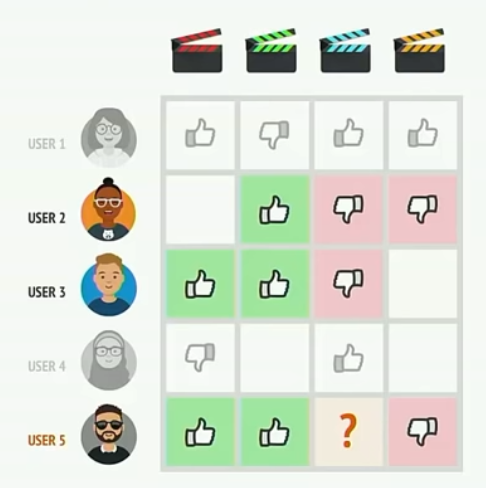


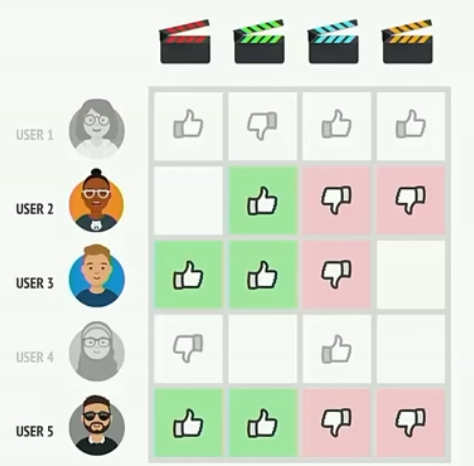



Dans ce travail nous implémenterons 2 modèles de ce type (le SVD basique qui servira de référence de comparaison, et le KNN WithMeans.




### Surprise/ Single Value Decomposition SVD ( CF Modèle Basique)





In [51]:
%%time

model = SVD().fit(train_set)

Wall time: 26.6 s


In [53]:
#Résultats

predict = model.test(test_set)

#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

print(f"Prédiction du score de l'utilisateur 0 pour la cat 281 : {model.predict(0, 281).est}")
print(f'Score exact : {df[(df["user_id"] == 0) & (df["category_id"] == 281)]["rating"].values}')

RMSE: 0.2103
MSE: 0.0442
MAE:  0.1682
Prédiction du score de l'utilisateur 0 pour la cat 281 : 0.6440929882736399
Score exact : [0.25]


In [55]:
predict

[Prediction(uid=31614, iid=99, r_ui=0.021739130434782608, est=0.12489947594723842, details={'was_impossible': False}),
 Prediction(uid=3980, iid=252, r_ui=0.047619047619047616, est=0.13589782488655094, details={'was_impossible': False}),
 Prediction(uid=40750, iid=317, r_ui=0.033707865168539325, est=0.13260252305613604, details={'was_impossible': False}),
 Prediction(uid=413, iid=429, r_ui=0.0049504950495049506, est=0.027117197236483023, details={'was_impossible': False}),
 Prediction(uid=47016, iid=281, r_ui=0.13043478260869565, est=0.629653459634157, details={'was_impossible': False}),
 Prediction(uid=6969, iid=118, r_ui=0.01, est=0.14854294840603366, details={'was_impossible': False}),
 Prediction(uid=28749, iid=118, r_ui=0.03225806451612903, est=0.13220568448995412, details={'was_impossible': False}),
 Prediction(uid=49974, iid=325, r_ui=0.07692307692307693, est=0.1781111004660719, details={'was_impossible': False}),
 Prediction(uid=1270, iid=442, r_ui=0.16666666666666666, est=0.23

In [56]:
# Mise en place de la fonction de prédiction
#Function from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n




In [57]:
top_n = get_top_n(predict, n=10)

In [58]:
# Fonction de prédiction finale
def make_recommendation(user_ID, top_n, df_rating, articles_df):
    """Return a list of recommanded articles based on the taste of the user and all recommended categories
    Args:
        user_id -> user id used for recommendation
        top_n -> top-N recommendation for each user from a set of predictions
        df_rating -> df used to train our algo
        articles_df -> df with metadata of all articles.
    Returns:
        list(recommanded articles), list(recommanded categories)
    """
    #Get top 5 cat and adding it to our list
    recommanded_cat = [iid for iid, _ in top_n[user_ID]]
    
    #If we don't have any recommandation, use our data.
    if not recommanded_cat:
        recommanded_cat = df[df['user_id'] == user_ID].nlargest(1, ['rating'])['category_id'].values
    
    #Select 5 randoms articles for each recommanded cat.
    random_articles_by_cat = [articles_df[articles_df['category_id'] == x]['article_id'].sample(5).values for x in recommanded_cat]
    
    #Select one of the recommanded cat and return 5 articles.
    rand_category = random.sample(random_articles_by_cat, 1)
    
    return rand_category[0], recommanded_cat

In [59]:
recommendation, categories = make_recommendation(1, top_n, df, articles_df)
print(f'Catégories recommandées pour le user_id[1] : {categories}')
print(f'Articles recommandés pour le  user_id[1] : {recommendation}')

Catégories recommandées pour le user_id[1] : [301]
Articles recommandés pour le  user_id[1] : [181410 180944 181414 181422 180442]


## KNNWithMeans


Entraînement du modèle

In [60]:
%%time 

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}

model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Wall time: 976 ms


In [61]:
#Résultats et prédiction

predict = model.test(test_set)


accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);


RMSE: 0.0993
MSE: 0.0099
MAE:  0.0505


In [62]:
print(f"Prédiction du score de l'utilisateur 0 pour la cat 281 : {model.predict(0, 281).est}")
print(f'Score exact : {df[(df["user_id"] == 0) & (df["category_id"] == 281)]["rating"].values}')

Prédiction du score de l'utilisateur 0 pour la cat 281 : 0.24460880849971353
Score exact : [0.25]


On obtient une très bonne prédiction. 
Application de la fonction de prédiction sur le jeu test avec le nouveau modèle...

In [63]:
top_n = get_top_n(predict, n=10)

recommendation, categories = make_recommendation(3, top_n, df, articles_df)

print(f'Catégories recommandées pour le user_id[3] : {categories}')
print(f'Articles recommandés pour le  user_id[3] : {recommendation}')

Catégories recommandées pour le user_id[3] : [281, 412]
Articles recommandés pour le  user_id[3] : [161084 151897 150835 153540 151041]


## Content_based Filtering


Le modèles de ce type ne se basent que sur l'historique des caractiristiques d'un utilisateur pour faire des prédictions...

### Modèle basique 

In [64]:
df_cb = df.copy()

#Add number total of rating for each
num_ratings = pd.DataFrame(df_cb.groupby('category_id').count()['rating']).reset_index()
df_cb = pd.merge(left=df_cb, right=num_ratings, on='category_id')
df_cb.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [65]:
#Category_id
def get_similar_category(category_id, df, n_ratings_filter=50, n_recommendations=5):
    matrix = df.pivot_table(
        index='user_id',
        columns='category_id',
        values='rating'
    )
    
    similar = matrix.corrwith(matrix[category_id])
    corr_similar = pd.DataFrame(similar, columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = df.copy()
    
    corr_with_category = pd.merge(
        left=corr_similar, 
        right=orig,
        on='category_id')[['category_id', 'correlation', 'numRatings']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_category[corr_with_category['numRatings'] > n_ratings_filter].sort_values(by='correlation', ascending=False)
    
    result = result[result['category_id'] != category_id]
    return result.head(n_recommendations)

In [66]:
result = get_similar_category(412, df_cb)

#Top 5 corr categories with category_id = 1
result.head(5)

,category_id,correlation,numRatings
41,123,0.853034,6289
112,285,0.824844,1162
166,396,0.783580,1343
137,339,0.764884,901
115,290,0.755583,61


Evaluation

In [67]:
train, test = sklearn.model_selection.train_test_split(df_cb, test_size=0.3, random_state=42, shuffle=True)

In [68]:
%%time

all_categories = train['category_id'].unique()
predictions = {}

for val in all_categories:
    predictions[val] = get_similar_category(val, train)

Wall time: 4min 12s


In [69]:
train[train['user_id'] == 2]

,user_id,category_id,rating,numRatings
501565,2,332,0.25,3071


In [70]:
predictions[332]

,category_id,correlation,numRatings
88,290,1.000000,61
132,402,1.000000,65
89,295,0.994762,79
58,207,0.990095,83
126,392,0.980944,198


In [73]:
test[test['user_id'] == 6]

,user_id,category_id,rating,numRatings
247383,6,431,0.028571,12732
214663,6,437,0.028571,21198
320751,6,289,0.028571,6426


In [74]:
predictions[431]

,category_id,correlation,numRatings
57,188,0.981917,75
61,207,0.964048,83
46,152,0.954739,168
89,285,0.933157,1162
123,369,0.931091,96


### Modèle basé sur l'embedding

In [79]:
with open(r"news-portal-user-interactions-by-globocom/articles_embeddings.pickle", "rb") as input_file:
    e = pickle.load(input_file)


In [82]:
frame = pd.concat(list_click_file_to_df, axis=0, ignore_index=True) # On recupère la table concatenée contenant toutes les variables

In [80]:
def getFiveArticles(e, userId):
    
    ee=e
    #get all articles read by user
    var= frame.loc[frame['user_id']==userId]['click_article_id'].tolist()
    #chose randomly one
    value = randint(0, len(var))
    #delete all read articles except the selected one( we do not want to offer user to read something he already read)
    for i in range(0, len(var)):
        if i != value:
            ee=np.delete(ee,[i],0)
    arr=[]
    
    #delete selected article in the new matrix
    f=np.delete(ee,[value],0)
    #get 5 articles the most similar to the selected one
    for i in range(0,5):
        distances = distance.cdist([ee[value]], f, "cosine")[0]
        min_index = np.argmin(distances)
        f=np.delete(f,[min_index],0)
        #find corresponding matrix in original matrix
        result = np.where(e == f[min_index])
        arr.append(result[0][0])
        
    return arr
        

In [87]:
print(getFiveArticles(e, 92059))

[711, 20, 26, 9, 440]


Nous allons choisir le modèle Knn pour le déploiement...


## Selection du meilleur modèle et déploiement


In [88]:
%%time

# Retrieve the trainset.
train_set = data.build_full_trainset()

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}

model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Wall time: 3.02 s


In [89]:
def predict_best_category_for_user(user_id, model, articles_df):
    predictions = {}
    
    #Category 1 to 460
    for i in range(1, 460):
        _, cat_id, _, est, err = model.predict(user_id, i)
        
        #Keep prediction only if we could keep it.
        if (err != True):
            predictions[cat_id] = est
    
    best_cats_to_recommend = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:5])
    
    recommended_articles = []
    for key, _ in best_cats_to_recommend.items():
        recommended_articles.append(int(articles_df[articles_df['category_id'] == key]['article_id'].sample(1).values))
    
    #return random_articles_for_best_cat, best_cat_to_recommend
    return recommended_articles, best_cats_to_recommend

In [91]:
results, recommended_cats = predict_best_category_for_user(1, model, articles_df)

print(f'Catégories recommandées : {recommended_cats}')
print(f'5 articles tirés au hasard de la meilleure catégorie {results}')

Catégories recommandées : {372: 0.5091550744398847, 22: 0.5, 70: 0.5, 159: 0.5, 171: 0.5}
5 articles tirés au hasard de la meilleure catégorie [227776, 24986, 43066, 78546, 79618]


In [92]:
# Sauvegarde du modèle
pkl_filename = "pickle_surprise_model_KNNWithMeans.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Chargement du modèle
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [93]:
# Vérif
results, recommended_cats = predict_best_category_for_user(1, pickle_model, articles_df)

print(f'Catégories recommandées : {recommended_cats}')
print(f'5 articles tirés au hasard de la meilleure catégorie {results}')

Catégories recommandées : {372: 0.5091550744398847, 22: 0.5, 70: 0.5, 159: 0.5, 171: 0.5}
5 articles tirés au hasard de la meilleure catégorie [227776, 24999, 43052, 78546, 79616]
